# Emojify 
Here we are going to use word vector representation to build an Emojifier.
This can automatically turn this :
>"Congratulations on the promotion! Let's get coffee and talk. Love you!"

To this :

>"Congratulations on the promotion! 👍  Let's get coffee and talk. ☕️ Love you! ❤️"

### Using Word Vectors to Improve Emoji Lookups
* In many emoji interfaces, we need to remember that ❤️  is the "heart" symbol rather than the "love" symbol. 
    * In other words, we'll have to remember to type "heart" to find the desired emoji, and typing "love" won't bring up that symbol.
* we can make a more flexible emoji interface by using word vectors!
* When using word vectors, we'll see that even if our training set explicitly relates only a few words to a particular emoji, our algorithm will be able to generalize and associate additional words in the test set to the same emoji.
    * This works even if those additional words don't even appear in the training set. 
    * This allows we to build an accurate classifier mapping from sentences to emojis, even using a small training set. 

### What we'll build:
1. In this exercise, we'll start with a baseline model (Emojifier-V1) using word embeddings.
2. Then we will build a more sophisticated model (Emojifier-V2) that further incorporates an LSTM. 

### Packages

In [1]:
import numpy as np
from emo_utils import*
import emoji
import matplotlib.pyplot as plt



## Baseline Model: Emojifer-V1
### Dataset EMOJISET

Let's start by building a simple baseline classifier. 

We have a tiny dataset (X, Y) where:
- X contains 127 sentences (strings).
- Y contains an integer label between 0 and 4 corresponding to an emoji for each sentence.

<img src="images/data_set.png" style="width:700px;height:300px;">

In [2]:
X_train, Y_train = read_csv('data/train_emoji.csv')
X_test, Y_test = read_csv('data/tesss.csv')

In [3]:
X_train.shape

(132,)

In [4]:
X_test.shape

(56,)

In [5]:
maxLen = len(max(X_train, key=len).split())
maxLen

10

In [6]:
for idx in range(10):
    print(X_train[idx], label_to_emoji(Y_train[idx]))

never talk to me again :disappointed:
I am proud of your achievements :smile:
It is the worst day in my life :disappointed:
Miss you so much ❤️
food is life 🍴
I love you mum ❤️
Stop saying bullshit :disappointed:
congratulations on your acceptance :smile:
The assignment is too long  :disappointed:
I want to go play ⚾


### Overview of the Emojifier-V1
<img src='./images/overview_of_v1.png'>

In [7]:
Y_oh_train = convert_to_one_hot(Y_train, C=5)
Y_oh_test = convert_to_one_hot(Y_test,C=5)

In [8]:
idx = 50
print(f"Sentence '{X_train[50]}' has label index {Y_train[idx]}, which is emoji {label_to_emoji(Y_train[idx])}", )
print(f"Label index {Y_train[idx]} in one-hot encoding format is {Y_oh_train[idx]}")

Sentence 'I missed you' has label index 0, which is emoji ❤️
Label index 0 in one-hot encoding format is [1. 0. 0. 0. 0.]


### Implementation of Emojifier-V1


In [9]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('data/glove.6B.50d.txt')

We've loaded:
- `word_to_index`: dictionary mapping from words to their indices in the vocabulary 
    - (400,001 words, with the valid indices ranging from 0 to 400,000)
- `index_to_word`: dictionary mapping from indices to their corresponding words in the vocabulary
- `word_to_vec_map`: dictionary mapping words to their GloVe vector representation. (50-dimensional)

In [10]:
word = "cucumber"
idx = 113317
print("the index of", word, "in the vocabulary is", word_to_index[word])
print("the", str(idx) + "th word in the vocabulary is", index_to_word[idx])

the index of cucumber in the vocabulary is 113317
the 113317th word in the vocabulary is cucumber


#### Implements `sentence_to_avg()`

In [11]:
def sentence_to_avg(sentence, word_to_vec_map):
    """
    Converts a sentence (string) into a list of words (strings). Extracts the GloVe representation of each word
    and averages its value into a single vector encoding the meaning of the sentence.
    
    Arguments:
    sentence -- string, one training example from X
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    
    Returns:
    avg -- average vector encoding information about the sentence, numpy-array of shape (50,)
    """
    any_word = list(word_to_vec_map.keys())[0]
    words = sentence.lower().split()
    l = 0
    avg = np.zeros(word_to_vec_map[any_word].shape)

    for w in words:
        if w in list(word_to_vec_map.keys()):
            avg += word_to_vec_map[w]
            l+=1
    
    if l > 0:
        avg = avg/l

    return avg

    

### Implements the Model
We now have all the pieces to finish implementing the `model()` function! 
After using `sentence_to_avg()` we need to:
* Pass the average through forward propagation
* Compute the cost
* Backpropagate to update the softmax parameters

Implement the `model()` function described in Figure (2). 

* The equations you need to implement in the forward pass and to compute the cross-entropy cost are below:
* The variable $Y_{oh}$ ("Y one hot") is the one-hot encoding of the output labels. 

$$ z^{(i)} = W . avg^{(i)} + b$$

$$ a^{(i)} = softmax(z^{(i)})$$

$$ \mathcal{L}^{(i)} = - \sum_{k = 0}^{n_y - 1} Y_{oh,k}^{(i)} * log(a^{(i)}_k)$$

**Note** : we will use loops to better understand the algorithm

In [12]:
def model(X, Y, word_to_vec_map, learning_rate = 0.01, num_iterations = 200):
    """
    Model to train word vector representations in numpy.
    
    Arguments:
    X -- input data, numpy array of sentences as strings, of shape (m, 1)
    Y -- labels, numpy array of integers between 0 and 7, numpy-array of shape (m, 1)
    word_to_vec_map -- dictionary mapping every word in a vocabulary into its 50-dimensional vector representation
    learning_rate -- learning_rate for the stochastic gradient descent algorithm
    num_iterations -- number of iterations
    
    Returns:
    pred -- vector of predictions, numpy-array of shape (m, 1)
    W -- weight matrix of the softmax layer, of shape (n_y, n_h)
    b -- bias of the softmax layer, of shape (n_y,)
    """
    any_word = list(word_to_vec_map.keys())[0]
    cost = 0
    m = Y.shape[0]
    n_y = len(np.unique(Y))
    n_h = word_to_vec_map[any_word].shape[0]

    W = np.random.rand(n_y, n_h) /np.sqrt(n_h)
    b = np.zeros((n_y,))

    Y_oh = convert_to_one_hot(Y,C=n_y)

    for t in range(num_iterations):
        for i in range(m):
            avg = sentence_to_avg(X[i],word_to_vec_map)
            
            #forward prop
            z = np.add(np.dot(W,avg),b)
            a = softmax(z)

            #cost
            cost = -np.sum(np.dot(Y_oh[i],np.log(a)))

            #backprop
            dz = a - Y_oh[i]
            dW = np.dot(dz.reshape(n_y,1),avg.reshape(1,n_h))
            db = dz 

            #update
            W = W - learning_rate * dW
            b = b - learning_rate * db 

            if i % 10 ==0:
                print("Epoch: " + str(t) + " --- cost = " + str(cost))
                pred = predict(X,Y,W,b,word_to_vec_map)
    

    return pred, W,b

        



In [14]:
print(X_train.shape)
print(Y_train.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(X_train[0])
print(type(X_train))
Y = np.asarray([5, 0, 0, 5, 4, 4, 4, 6, 6, 4, 1, 1, 5, 6, 6, 3, 6, 3, 4, 4])
print(Y.shape)

X = np.asarray(['I am going to the bar tonight', 'I love you', 'miss you my dear',
 'Lets go party and have drinks','Congrats on the new job','Congratulations',
 'I am so happy for you', 'Why are you feeling bad', 'What is wrong with you',
 'You totally deserve this prize', 'Let us go play football',
 'Are you down for football this afternoon', 'Work hard play harder',
 'It is surprising how people can be dumb sometimes',
 'I am very disappointed','It is the best day in my life',
 'I think I will end up alone','My life is so boring','Good job',
 'Great so awesome'])

print(X.shape)
print(np.eye(5)[Y_train.reshape(-1)].shape)
print(type(X_train))

(132,)
(132,)
(132, 5)
never talk to me again
<class 'numpy.ndarray'>
(20,)
(20,)
(132, 5)
<class 'numpy.ndarray'>


In [15]:
np.random.seed(1)
pred , W, b = model(X_train, Y_train, word_to_vec_map)
print(pred)

Epoch: 0 --- cost = 1.6325266598703185
Accuracy: 0.2196969696969697
Epoch: 0 --- cost = 1.31511515631959
Accuracy: 0.2803030303030303
Epoch: 0 --- cost = 1.1096871792248777
Accuracy: 0.2803030303030303
Epoch: 0 --- cost = 2.0780418843028015
Accuracy: 0.2727272727272727
Epoch: 0 --- cost = 0.9942393316543748
Accuracy: 0.2727272727272727
Epoch: 0 --- cost = 1.9375195920482373
Accuracy: 0.25
Epoch: 0 --- cost = 1.1814770173191946
Accuracy: 0.29545454545454547
Epoch: 0 --- cost = 1.772829576659144
Accuracy: 0.32575757575757575
Epoch: 0 --- cost = 1.238825476537914
Accuracy: 0.26515151515151514
Epoch: 0 --- cost = 1.5177781474996912
Accuracy: 0.4772727272727273
Epoch: 0 --- cost = 1.2978760615115696
Accuracy: 0.38636363636363635
Epoch: 0 --- cost = 1.9136687386211144
Accuracy: 0.2878787878787879
Epoch: 0 --- cost = 1.9175983452813699
Accuracy: 0.5151515151515151
Epoch: 0 --- cost = 1.7167260669629125
Accuracy: 0.3484848484848485
Epoch: 1 --- cost = 1.1886907604751338
Accuracy: 0.29545454545

KeyboardInterrupt: 

In [17]:
W = np.load("weights.npy")
b = np.load("biases.npy")

### Examining Test Set Performance


In [18]:
print("Training Set")
pred_train = predict(X_train, Y_train, W,b, word_to_vec_map)
print("Test Set")
pred_test = predict(X_test, Y_test, W,b, word_to_vec_map)


Training Set
Accuracy: 0.9545454545454546
Test Set
Accuracy: 0.8571428571428571


In [19]:
def predict_single(sentence, W=W, b=b, word_to_vec_map=word_to_vec_map):
    """
    Given X (sentences) and Y (emoji indices), predict emojis and compute the accuracy of your model over the given set.
    
    Arguments:
    X -- input data containing sentences, numpy array of shape (m, None)
    Y -- labels, containing index of the label emoji, numpy array of shape (m, 1)
    
    Returns:
    pred -- numpy array of shape (m, 1) with your predictions
    """
    any_words = list(word_to_vec_map.keys())[0]
    n_h = word_to_vec_map[any_words].shape[0]

    words = sentence.lower().split()
    
    avg = np.zeros((n_h,))
    count = 0
    for w in words:
        if w in word_to_vec_map:
            avg += word_to_vec_map[w]
            count +=1 
    
    if count > 0:
        avg = avg/count

    Z = np.dot(W,avg) + b
    A = softmax(Z)
    pred = np.argmax(A)

    return pred

In [20]:
label_to_emoji(int(predict_single("let's play")))

'⚾'

let try with the word it has never seen before \
we will try with "I adore you" and "adore" didnot appear in the training set.

In [21]:
X_my_sentences = np.array(["i adore you", "i love you", "funny lol", "lets play with a ball", "food is ready", "not feeling happy"])
Y_my_labels = np.array([[0], [0], [2], [1], [4],[3]])

pred = predict(X_my_sentences, Y_my_labels , W, b, word_to_vec_map)
print_predictions(X_my_sentences, pred)

Accuracy: 0.8333333333333334

i adore you ❤️
i love you ❤️
funny lol :smile:
lets play with a ball ⚾
food is ready 🍴
not feeling happy :smile:


#### Word Ordering isn't Considered in this Model
* Note that the model doesn't get the following sentence correct:
>"not feeling happy" 

* This algorithm ignores word ordering, so is not good at understanding phrases like "not happy

### Confusion Matrix
* A confusion matrix shows how often an example whose label is one class ("actual" class) is mislabeled by the algorithm with a different class ("predicted" class).

(56,)
           ❤️    ⚾    :smile:    :disappointed:   🍴
Predicted  0.0  1.0  2.0  3.0  4.0  All
Actual                                 
0            6    0    0    1    0    7
1            0    8    0    0    0    8
2            2    0   16    0    0   18
3            1    1    2   12    0   16
4            0    0    1    0    6    7
All          9    9   19   13    6   56


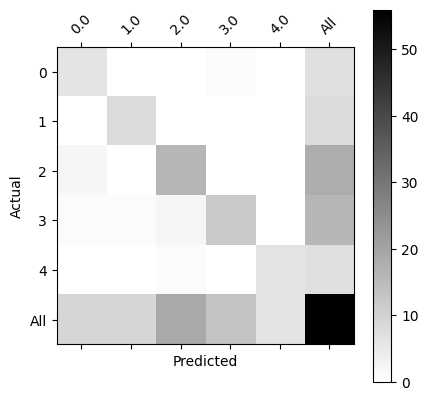

In [22]:
print(Y_test.shape)
print('           '+ label_to_emoji(0)+ '    ' + label_to_emoji(1) + '    ' +  label_to_emoji(2)+ '    ' + label_to_emoji(3)+'   ' + label_to_emoji(4))
print(pd.crosstab(Y_test, pred_test.reshape(56,), rownames=['Actual'], colnames=['Predicted'], margins=True))
plot_confusion_matrix(Y_test, pred_test)